In [1]:
import numpy as np
import pandas as pd
import matplotlib

In [2]:
import matplotlib.pyplot as plt

In [3]:
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
import seaborn as sns

In [4]:
import xarray as xr
import cudf

In [5]:
from progress.bar import Bar

In [6]:
import gc

In [7]:
gc.enable()

## Load .nc in xarray for province

In [8]:
province_no = 2
filename = '/home/jovyan/lustre_scratch/province_dataframes/full_province'+str(province_no)+'.nc'

In [25]:
d = xr.load_dataset(filename)

In [26]:
d = d.sel(longitude=slice(-25,10)) 
#d = d.sel(longitude=slice(10,45)) 

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from matplotlib.colors import LinearSegmentedColormap

ERROR 1: PROJ: proj_create_from_database: Open of /home/jovyan/lustre_scratch/conda-envs/rapids_env/share/proj failed


## Make colourmap for coccolithphores

In [13]:
colors = [(0, 24/255, 95/255),(0, 154/255, 162/255),(126/255, 201/255, 201/255),(173/255, 255/255, 251/255)]#,(1, 1, 1)]
cmap = LinearSegmentedColormap.from_list('coccolithphores', colors, N=100)

# Plot example for Figure 2

/home/jovyan/lustre_scratch/conda-envs/rapids_env/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/jovyan/lustre_scratch/conda-envs/rapids_env/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


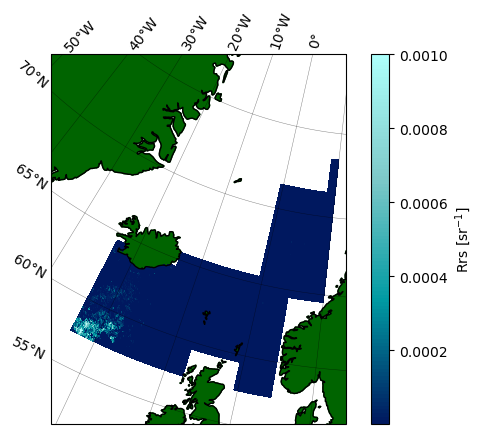

In [27]:

d_test=d.sel(time='2008-08-01')

ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=20.0, central_latitude=45.0,cutoff=40))
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,x_inline=False, y_inline=False, linewidth=0.33, color='k',alpha=0.5)
ax.set_extent([-25,10,56,77], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeat.LAND,color='darkgreen')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
gl.xlabels_bottom = False
gl.ylabels_right = False
im = ax.pcolor(d_test['longitude'],d_test['latitude'],d_test['rrs'],cmap=cmap,vmin=1e-6,vmax=1e-3,transform=ccrs.PlateCarree())
cbar = plt.colorbar(im)
cbar.set_label('Rrs [sr$^{-1}$]')
plt.show()

### Set up for k fold split

In [18]:
#slices
slice_1 = slice('1998-01-01','2000-12-01')
slice_2 = slice('2001-01-01','2004-12-01')
slice_3 = slice('2005-01-01','2008-12-01')
slice_4 = slice('2009-01-01','2012-12-01')
slice_5 = slice('2013-01-01','2016-12-01')

In [19]:
#fold 1
training_1=xr.concat([d.sel(time=slice_1),d.sel(time=slice_2),d.sel(time=slice_3),d.sel(time=slice_4)],'time')
test_1=d.sel(time=slice_5)

#fold 2
training_2 = xr.concat([d.sel(time=slice_1),d.sel(time=slice_2),d.sel(time=slice_3),d.sel(time=slice_5)],'time')
test_2 = d.sel(time=slice_4)

#fold 3 
training_3=xr.concat([d.sel(time=slice_1),d.sel(time=slice_2),d.sel(time=slice_4),d.sel(time=slice_5)],'time')
test_3= d.sel(time=slice_3)

#fold 4 
training_4 = xr.concat([d.sel(time=slice_1),d.sel(time=slice_3),d.sel(time=slice_4),d.sel(time=slice_5)],'time')
test_4 = d.sel(time=slice_2)

#fold 5 
training_5 = xr.concat([d.sel(time=slice_2),d.sel(time=slice_3),d.sel(time=slice_4),d.sel(time=slice_5)],'time')
test_5 = d.sel(time=slice_1)


In [20]:
training = [training_1,training_2,training_3,training_4,training_5]
test = [test_1,test_2,test_3,test_4,test_5]

## Decide on limit for classifier

In [21]:
stacked = d.stack(coord=['longitude', 'latitude']).to_dataframe()
stacked.drop(columns=['spatial_ref','longitude', 'latitude'],inplace=True)
stacked.dropna(inplace=True)
stacked.reset_index(drop=True,inplace=True)

In [23]:
std = stacked.rrs.std()
print(std)

8.301821274534806e-06


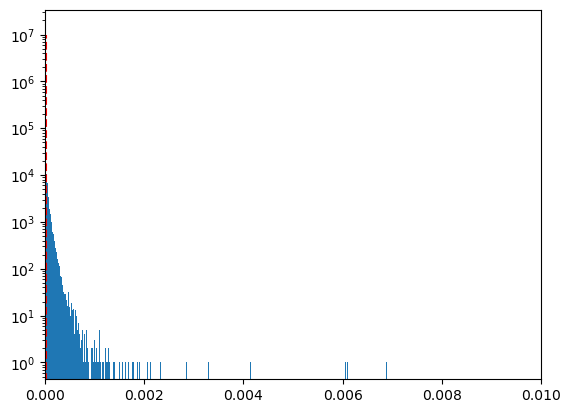

In [25]:
fig, ax = plt.subplots(1,1)
ax.hist(stacked['rrs'],bins=1000)
ax.plot(np.tile(std,50),np.linspace(0,10000000),color='red',linestyle='--')
ax.set_yscale('log')
ax.set_xlim([0,1e-2])
plt.show()

In [26]:
del d #for memory purposes

## K fold validation - using fold 3 for final model

In [27]:
from progressbar import ProgressBar
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

  0% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

<xarray.Dataset>
Dimensions:           (longitude: 500, latitude: 140, time: 167)
Coordinates:
  * longitude         (longitude) float64 -77.44 -77.35 -77.25 ... -27.65 -27.55
  * latitude          (latitude) float64 25.55 25.65 25.75 ... 39.25 39.35 39.45
  * time              (time) datetime64[ns] 1998-01-01 1998-02-01 ... 2015-12-01
    spatial_ref       int64 0
Data variables:
    rrs               (time, latitude, longitude) float64 0.0 0.0 ... nan nan
    SST               (time, latitude, longitude) float32 297.7 297.7 ... nan
    Wind speed mean   (time, latitude, longitude) float64 7.48 7.501 ... nan nan
    Wind speed std    (time, latitude, longitude) float64 2.264 2.286 ... nan
    Wind stress mean  (time, latitude, longitude) float64 0.09668 ... nan
    Wind stress std   (time, latitude, longitude) float64 0.06422 ... nan
    SLA               (time, latitude, longitude) float64 0.0239 0.0239 ... nan
    MLD               (time, latitude, longitude) float32 29.5 29.5 ... n

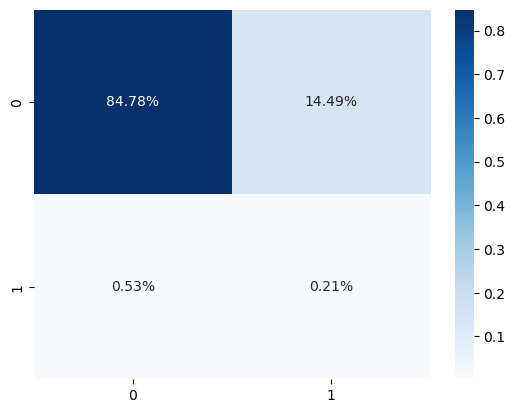

100% (1 of 1) |##########################| Elapsed Time: 0:02:33 Time:  0:02:33


In [28]:
pbar = ProgressBar()
for i in pbar(range(3,4)):
    print(training[i])
    print(test[i])
    stacked_train = training[i].stack(coord=['longitude', 'latitude']).to_dataframe()
    stacked_test = test[i].stack(coord=['longitude', 'latitude']).to_dataframe()
    
    stacked_train.drop(columns=['spatial_ref','longitude', 'latitude'],inplace=True)
    stacked_test.drop(columns=['spatial_ref','longitude', 'latitude'],inplace=True)
    
    stacked_train.dropna(inplace=True)
    stacked_test.dropna(inplace=True)
    
    stacked_train.reset_index(drop=True,inplace=True)
    stacked_test.reset_index(drop=True,inplace=True)
    print(stacked_train.rrs.std()*2)
    stacked_train['rrs'].where(stacked_train['rrs']<std, other=1, inplace=True)
    #stacked_train['rrs'].where(stacked_train['rrs']>0.00006, other=0, inplace=True)
    rrs_ones = (stacked_train['rrs'] == 1).sum()
    rrs_zeros = (stacked_train['rrs'] == 0).sum()

    non_zero = stacked_train.loc[stacked_train['rrs'] == 1.]
    non_zero = non_zero[stacked_train.columns]
    print(non_zero.shape)
    zero = stacked_train.loc[stacked_train['rrs'] == 0.]
    zero = zero[stacked_train.columns]
    #zero_samp = zero.sample(rrs_ones)

    full = pd.concat([zero,non_zero])
    stacked_train=full
    
    
    stacked_test['rrs'].where(stacked_test['rrs']<std, other=1, inplace=True)
    #stacked_test['rrs'].where(stacked_test['rrs']>0.00006, other=0, inplace=True)
    rrs_ones = (stacked_test['rrs'] == 1).sum()
    rrs_zeros = (stacked_test['rrs'] == 0).sum()

    non_zero = stacked_test.loc[stacked_test['rrs'] == 1.]
    non_zero = non_zero[stacked_test.columns]

    zero = stacked_test.loc[stacked_test['rrs'] == 0.]
    zero = zero[stacked_test.columns]
    zero_samp = zero.sample(rrs_ones)

    full_test = pd.concat([zero,non_zero])
    stacked_test=full_test
    print(stacked_test.describe())
    
    gc.collect()
    
    X_train = stacked_train.drop(columns='rrs')
    y_train = stacked_train['rrs']
    
    X_test = stacked_test.drop(columns='rrs')
    y_test = stacked_test['rrs']
    
    rf = BalancedRandomForestClassifier(class_weight='balanced_subsample',n_estimators=100, max_depth=8, n_jobs=-1) #,class_weight='balanced_subsample',max_depth=5) #,max_depth=20,n_estimators=500) #n_estimators=2000, max_features='auto',verbose=False, min_samples_split= 8, max_depth=5,class_weight='balanced')
    
    rf.fit(X_train,y_train)
    
    gc.collect()
    
    cuml_train_accuracy = rf.score(X_train, y_train)
    cuml_test_accuracy = rf.score(X_test, y_test)
    print(f'Training accuracy fold {i} = {cuml_train_accuracy}, Test accuracy fold {i} = {cuml_test_accuracy}')
    
    #Confusion matrix
    #cm = confusion_matrix(y_test,rf.predict(X_test))/y_test.size
    #sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    #plt.show()

## Save out model

In [75]:
import joblib

In [76]:
# save
joblib.dump(rf, "/home/jovyan/lustre_scratch/models/random_forest_"+str(province_no)+".joblib", compress=3)

['/home/jovyan/lustre_scratch/models/random_forest_2_otherhalf.joblib']